In [ ]:
# -*- coding: utf-8 -*-
"""
EDGAR Log Analysis - Notebook Version (Folder Input)

Leverages a full month of data (multiple CSVs), LSTM Autoencoder, Parquet, Spark SQL.
"""

# %% [markdown]
# ## 1. Environment Setup
# Install Java, download and extract Spark, install required Python libraries.

# %%
# Install Java
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
print("Java installed.")

# Download Spark 3.4.1 from a stable mirror
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
print("Spark downloaded.")

# Extract Spark
!tar -xzf spark-3.4.1-bin-hadoop3.tgz
print("Spark extracted.")

# Install Findspark, Scikit-learn, TensorFlow and PyArrow
!pip install -q findspark scikit-learn tensorflow pyarrow
print("Python libraries installed.")



Java installed.
Spark downloaded.
Spark extracted.
Python libraries installed.


In [ ]:

# %% [markdown]
# ## 2. Configure Environment Variables & Initialize Spark

# %%
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

import findspark
findspark.init()
print("Spark environment configured.")



Spark environment configured.


In [ ]:
# %% [markdown]
# ## 3. Imports
# **Correction:** Added import for google.colab.drive and os module.

# %%
import os # <-- Added import os here for os.path.exists
from pyspark.sql import SparkSession
from pyspark.sql import functions as F # Use F alias for Spark functions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ML/DL Imports
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from tensorflow.keras.callbacks import EarlyStopping

# Google Drive specific import
from google.colab import drive

print("Imports completed.")


Imports completed.


In [ ]:
# %% [markdown]
# ## 4. Create Spark Session
# **Correction:** Removed indentation from the comment line to resolve IndentationError.

# %%
spark = SparkSession.builder \
    .appName("EDGARLogAnalysisEcosystemNotebook") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.parquet.writeLegacyFormat", "true") \
    .getOrCreate()

print("Spark Session Created")
print(spark)

Spark Session Created


In [ ]:
# %% [markdown]
# ## 4.5 Mount Google Drive
# This cell connects your Google Drive to the Colab environment, allowing access to your files. You will likely be prompted to authorize access.

# %%
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    # Consider stopping if Drive access is essential
    # spark.stop()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


In [ ]:

# ## 5. Load Data from Google Drive Folder
# **IMPORTANT:** Replace the `your_folder_name_in_drive` part below with the actual name and path of the folder within your Google Drive where the CSV files are located.

# %%
# --- Load Data ---
# IMPORTANT: Update the path below to point to your folder within Google Drive
# Example: If your folder is directly inside 'My Drive' and named 'EDGAR_Logs_Monthly',
# the path would be '/content/drive/MyDrive/EDGAR_Logs_Monthly/'
drive_folder_path = "/content/drive/MyDrive/1monthdataset" # <--- CHANGE THIS PATH

try:
    # Check if the path exists before trying to read
    if not os.path.exists(drive_folder_path):
         raise FileNotFoundError(f"The specified Google Drive path does not exist: {drive_folder_path}")

    # Spark can read all CSV files within a directory
    # Ensure all CSVs have the same header and schema
    df = spark.read.csv(
        drive_folder_path,
        header=True,        # Assumes first line is header
        inferSchema=True,   # Infers data types (can be slow for many files, consider defining schema explicitly)
        timestampFormat="yyyy-MM-dd'T'HH:mm:ss.SSSX" # Specify format if needed for _time
    )
    print(f"Attempting to load data from folder: {drive_folder_path}")
    # Ensure _time column is timestamp type (might be redundant if inferSchema worked, but safer)
    df = df.withColumn("_time", F.to_timestamp(F.col("_time")))
    print(f"Successfully loaded initial data. Record count: {df.count()}")
    print("Sample of loaded data:")
    df.show(5, truncate=False)
except FileNotFoundError as fnf_error:
    print(fnf_error)
    print("Please double-check the path in the 'drive_folder_path' variable.")
    # spark.stop() # Optional: stop if data loading fails
except Exception as e:
    print(f"Error loading data from {drive_folder_path}: {e}")
    print("Please ensure the path is correct and the CSV files have consistent headers.")
    # spark.stop() # Optional: stop if data loading fails


Attempting to load data from folder: /content/drive/MyDrive/1monthdataset
Successfully loaded initial data. Record count: 35045363
Sample of loaded data:
+-------------------+--------------------------------------------------------------------+
|_time              |uri_path                                                            |
+-------------------+--------------------------------------------------------------------+
|2020-06-02 21:35:16|/Archives/edgar/data/943184/000114420408043594/v121751_ex99-1.htm   |
|2020-06-02 21:35:16|/Archives/edgar/data/829365/000119312513352900/d591926d6k.htm       |
|2020-06-02 21:35:16|/Archives/edgar/data/1596856/000104746914002226/a2218693zex-10_6.htm|
|2020-06-02 21:35:16|/Archives/edgar/data/1329099/000119312514120068/d641077dex469.htm   |
|2020-06-02 21:35:16|/Archives/edgar/data/931336/0001588305-15-000064.txt                |
+-------------------+--------------------------------------------------------------------+
only showing top 5 rows



In [ ]:

# %% [markdown]
# ## 6. Initial Exploration & Cleaning

# %%
# Check if df was loaded successfully
if 'df' in locals() and df is not None:
    print("Schema:")
    df.printSchema()

    # Drop rows with nulls in essential columns
    df = df.na.drop(subset=["_time", "uri_path"])
    print(f"Records after dropping nulls: {df.count()}")

    # Check if DataFrame is empty after cleaning
    if df.count() == 0:
        print("No data remaining after cleaning. Stopping.")
        spark.stop()
        # exit() # Or raise an error
else:
    print("DataFrame 'df' not loaded successfully in the previous step.")


Schema:
root
 |-- _time: timestamp (nullable = true)
 |-- uri_path: string (nullable = true)

Records after dropping nulls: 35045256


In [ ]:

# %% [markdown]
# ## 7. Aggregate to HOURLY Hits (Spark)

# %%
if 'df' in locals() and df is not None and df.count() > 0:
    print("Aggregating hits per hour...")
    # Extract date and hour parts
    df = df.withColumn("date", F.to_date(F.col("_time")))
    df = df.withColumn("hour", F.hour(F.col("_time")))

    # Create a timestamp rounded to the hour for easier joining/sorting later
    df = df.withColumn("hourly_timestamp",
                       F.concat_ws(" ", F.col("date").cast("string"), F.lpad(F.col("hour").cast("string"), 2, '0')) \
                       .cast("timestamp"))

    # Group by the hourly timestamp and count hits
    hourly_hits = df.groupBy("hourly_timestamp") \
                    .agg(F.count("*").alias("hourly_hit_count")) \
                    .orderBy("hourly_timestamp")

    print("Hourly aggregation complete.")
    hourly_hits.show(5, truncate=False)
else:
    print("Skipping hourly aggregation as input DataFrame is not valid.")
    hourly_hits = None # Ensure variable exists


Aggregating hits per hour...
Hourly aggregation complete.
+-------------------+----------------+
|hourly_timestamp   |hourly_hit_count|
+-------------------+----------------+
|2020-06-01 06:00:00|227410          |
|2020-06-01 16:00:00|226017          |
|2020-06-01 17:00:00|222315          |
|2020-06-02 04:00:00|276014          |
|2020-06-02 05:00:00|305789          |
+-------------------+----------------+
only showing top 5 rows



In [ ]:
# %% [markdown]
# ## 8. Save Aggregated Data to Parquet
# This demonstrates using an efficient columnar storage format common in Big Data pipelines.

# %%
if hourly_hits is not None:
    parquet_path = "/content/hourly_hits.parquet"
    print(f"Saving aggregated hourly hits to Parquet format at: {parquet_path}")
    try:
        # Use overwrite mode for reruns, coalesce to reduce number of output files in local mode
        hourly_hits.coalesce(1).write.mode("overwrite").parquet(parquet_path)
        print("Successfully saved to Parquet.")
    except Exception as e:
        print(f"Error saving to Parquet: {e}")
else:
    print("Skipping Parquet save as hourly aggregation was not performed.")


Saving aggregated hourly hits to Parquet format at: /content/hourly_hits.parquet
Successfully saved to Parquet.


In [ ]:

# %% [markdown]
# ## 9. Load Aggregated Data from Parquet
# This shows how to read the optimized Parquet format back into a Spark DataFrame.

# %%
# Define path regardless of whether saving succeeded, attempt to load
parquet_path = "/content/hourly_hits.parquet"
print(f"\nLoading aggregated data back from Parquet: {parquet_path}")
try:
    hourly_hits_from_parquet = spark.read.parquet(parquet_path)
    print("Successfully loaded from Parquet.")
    hourly_hits_from_parquet.show(5, truncate=False)
    # Use this DataFrame for subsequent steps
    hourly_hits_for_ml = hourly_hits_from_parquet
except Exception as e:
    print(f"Error loading from Parquet: {e}")
    # Fallback only if hourly_hits exists in memory
    if 'hourly_hits' in locals() and hourly_hits is not None:
        print("Falling back to in-memory DataFrame.")
        hourly_hits_for_ml = hourly_hits
    else:
        print("Cannot fall back, no valid hourly data available.")
        hourly_hits_for_ml = None


Loading aggregated data back from Parquet: /content/hourly_hits.parquet
Successfully loaded from Parquet.
+-------------------+----------------+
|hourly_timestamp   |hourly_hit_count|
+-------------------+----------------+
|2020-06-01 06:00:00|227410          |
|2020-06-01 16:00:00|226017          |
|2020-06-01 17:00:00|222315          |
|2020-06-02 04:00:00|276014          |
|2020-06-02 05:00:00|305789          |
+-------------------+----------------+
only showing top 5 rows



In [ ]:

# %% [markdown]
# ## 10. Convert to Pandas & Prepare Time Series for ML
# Convert the aggregated Spark DataFrame to Pandas, set a proper DatetimeIndex, and ensure the time series is complete (no missing hours).

# %%
hourly_hits_pd = pd.DataFrame() # Initialize empty DataFrame
if hourly_hits_for_ml is not None:
    print("\nConverting aggregated data to Pandas for ML...")
    try:
        hourly_hits_pd = hourly_hits_for_ml.toPandas()

        # Ensure hourly_timestamp is datetime and set as index
        hourly_hits_pd['hourly_timestamp'] = pd.to_datetime(hourly_hits_pd['hourly_timestamp'])
        hourly_hits_pd.set_index('hourly_timestamp', inplace=True)

        # Ensure numeric type and handle potential errors
        hourly_hits_pd['hourly_hit_count'] = pd.to_numeric(hourly_hits_pd['hourly_hit_count'], errors='coerce')
        hourly_hits_pd.dropna(inplace=True) # Drop if conversion failed

        # **Crucial Step for Time Series:** Ensure a complete time index for the period.
        if not hourly_hits_pd.empty:
            min_date = hourly_hits_pd.index.min()
            max_date = hourly_hits_pd.index.max()
            # Create the full hourly range
            full_range = pd.date_range(start=min_date.floor('h'), end=max_date.ceil('h'), freq='h')
            # Reindex the dataframe, filling missing hours with 0 hits
            hourly_hits_pd = hourly_hits_pd.reindex(full_range, fill_value=0)
            print(f"Pandas DataFrame ready for ML. Shape: {hourly_hits_pd.shape}")
            print(hourly_hits_pd.head())
        else:
            print("Pandas DataFrame is empty after processing.")
            hourly_hits_pd = pd.DataFrame() # Reset to empty if processing failed

    except Exception as e:
        print(f"Error converting Spark DataFrame to Pandas or processing: {e}")
        hourly_hits_pd = pd.DataFrame() # Reset to empty on error
else:
    print("Skipping Pandas conversion as input Spark DataFrame is not valid.")



Converting aggregated data to Pandas for ML...
Pandas DataFrame ready for ML. Shape: (717, 1)
                     hourly_hit_count
2020-06-01 06:00:00            227410
2020-06-01 07:00:00                 0
2020-06-01 08:00:00                 0
2020-06-01 09:00:00                 0
2020-06-01 10:00:00                 0


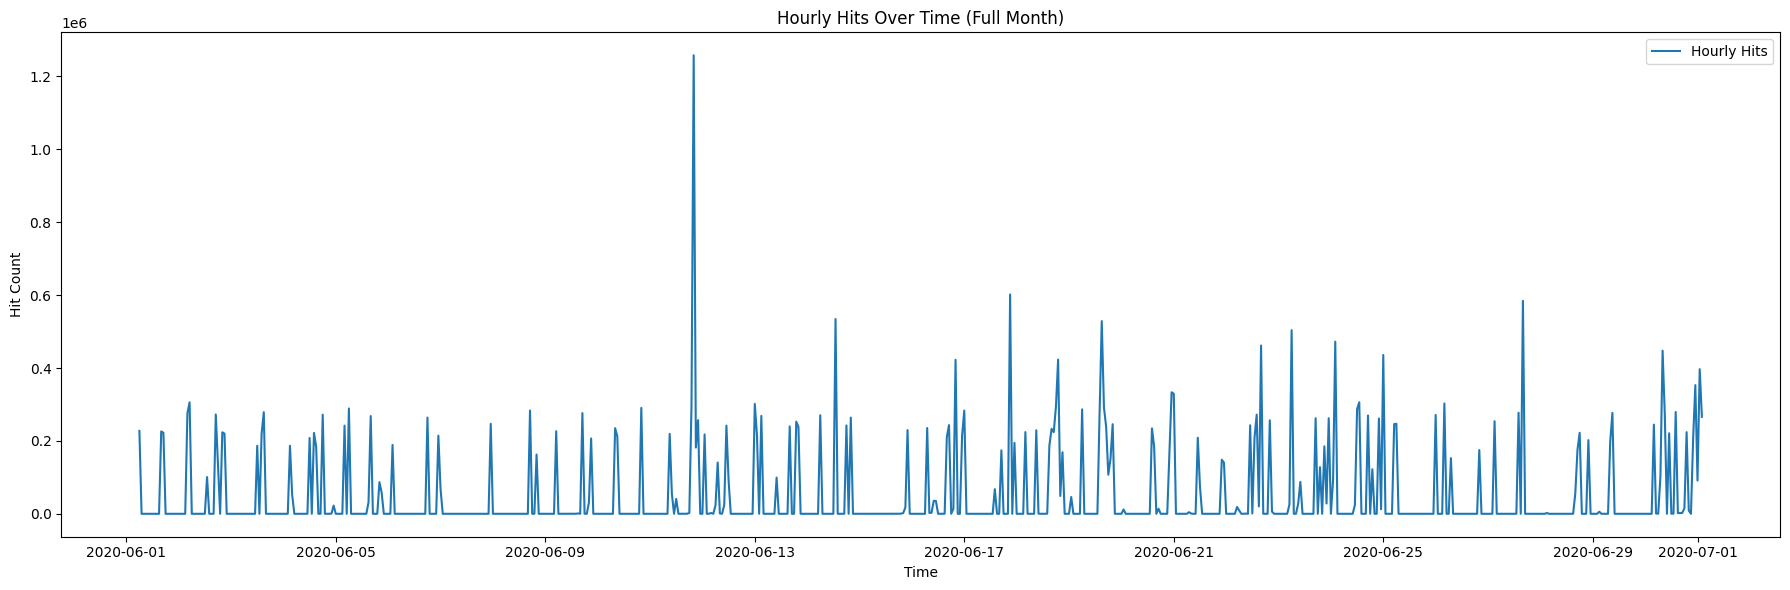

In [ ]:

# %% [markdown]
# ## 11. Visualize Hourly Data

# %%
if not hourly_hits_pd.empty:
    plt.figure(figsize=(18, 6))
    plt.plot(hourly_hits_pd.index, hourly_hits_pd['hourly_hit_count'], label='Hourly Hits')
    plt.title('Hourly Hits Over Time (Full Month)')
    plt.xlabel('Time')
    plt.ylabel('Hit Count')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No data to visualize.")


In [ ]:

# %% [markdown]
# ## 12. Scale Data
# Scale the hit counts to a 0-1 range, which is generally beneficial for neural network training.

# %%
if not hourly_hits_pd.empty:
    print("Scaling data...")
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Reshape for scaler (expects 2D)
    hourly_hits_pd['scaled_hits'] = scaler.fit_transform(hourly_hits_pd['hourly_hit_count'].values.reshape(-1, 1))
    print(hourly_hits_pd[['hourly_hit_count', 'scaled_hits']].head())
else:
    print("No data to scale.")


Scaling data...
                     hourly_hit_count  scaled_hits
2020-06-01 06:00:00            227410     0.180733
2020-06-01 07:00:00                 0     0.000000
2020-06-01 08:00:00                 0     0.000000
2020-06-01 09:00:00                 0     0.000000
2020-06-01 10:00:00                 0     0.000000


In [ ]:

# %% [markdown]
# ## 13. Create Sequences for LSTM
# Define a function to transform the time series into overlapping sequences suitable for LSTM input.

# %%
def create_sequences(values, time_steps):
    """
    Creates sequences from time series data.
    Args:
        values (np.array): Array of time series values.
        time_steps (int): Length of each sequence.
    Returns:
        np.array: Array of sequences.
    """
    output_X = []
    for i in range(len(values) - time_steps + 1):
        output_X.append(values[i : (i + time_steps)])
    return np.array(output_X)


In [ ]:

# %% [markdown]
# ## 14. Generate Sequences

# %%
X_sequences = np.array([]) # Initialize empty
if 'scaled_hits' in hourly_hits_pd.columns and not hourly_hits_pd.empty:
    TIME_STEPS = 24 * 7 # Number of hours in each sequence (e.g., look at past week)

    # Create sequences from scaled data
    X_sequences = create_sequences(hourly_hits_pd['scaled_hits'].values, TIME_STEPS)

    # Reshape sequences for LSTM input [samples, time_steps, features]
    if X_sequences.size > 0:
        X_sequences = X_sequences.reshape((X_sequences.shape[0], X_sequences.shape[1], 1))
        print(f"Created sequences with shape: {X_sequences.shape}") # Should be [num_sequences, TIME_STEPS, 1]
    else:
        print(f"Not enough data ({len(hourly_hits_pd)} points) to create sequences with TIME_STEPS={TIME_STEPS}.")
        X_sequences = np.array([]) # Ensure it's empty

else:
    print("Scaled data not available. Skipping sequence generation.")


Created sequences with shape: (550, 168, 1)


In [ ]:

# %% [markdown]
# ## 15. Build LSTM Autoencoder Model

# %%
model = None # Initialize
if X_sequences.size > 0:
    print("Building LSTM Autoencoder model...")

    n_features = X_sequences.shape[2] # Should be 1 (just hit count)

    # Using Keras Functional API
    inputs = Input(shape=(TIME_STEPS, n_features))
    # Encoder - adjust units based on TIME_STEPS complexity
    encoded = LSTM(128, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(64, activation='relu', return_sequences=False)(encoded) # Get final encoded state
    # Repeat vector to match decoder input shape
    vector = RepeatVector(TIME_STEPS)(encoded)
    # Decoder - mirror encoder structure
    decoded = LSTM(64, activation='relu', return_sequences=True)(vector)
    decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
    # Output layer
    output = TimeDistributed(Dense(n_features))(decoded) # Use n_features here

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mae') # Mean Absolute Error is often good for reconstruction
    model.summary()
else:
    print("No sequences generated. Skipping model building.")


Building LSTM Autoencoder model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 168, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 168, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 168, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 168, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 168, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,937 (968.50 KB)

 Trainable params: 247,937 (968.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# %% [markdown]
# ## 16. Train the Model

# %%
history = None # Initialize
if model is not None and X_sequences.size > 0:
    print("Training the model...")
    # Use early stopping to prevent overfitting and save time
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True) # Increased patience

    # Train the autoencoder to reconstruct its input
    # Use a portion of data for validation
    history = model.fit(X_sequences, X_sequences, # Input and Target are the same
                        epochs=30, # Increased epochs for potentially more complex patterns
                        batch_size=64, # Adjust batch size based on memory/data size
                        validation_split=0.1, # Use 10% of data for validation
                        callbacks=[early_stopping],
                        shuffle=False) # Keep sequence order
    print("Model training complete.")
else:
    print("Model not built or no sequences available. Skipping training.")


Training the model...
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - loss: 0.0350 - val_loss: 0.0392
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.0339 - val_loss: 0.0388
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.0336 - val_loss: 0.0385
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.0335 - val_loss: 0.0388
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0336 - val_loss: 0.0385
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0334 - val_loss: 0.0386
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0335 - val_loss: 0.0384
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0335 - val_loss: 0.0386
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0335 - val_loss: 0.0386
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0336 - val_loss: 0.0389
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.0338 - val_loss: 0.0389
Epoch 12/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.0338 - val_loss

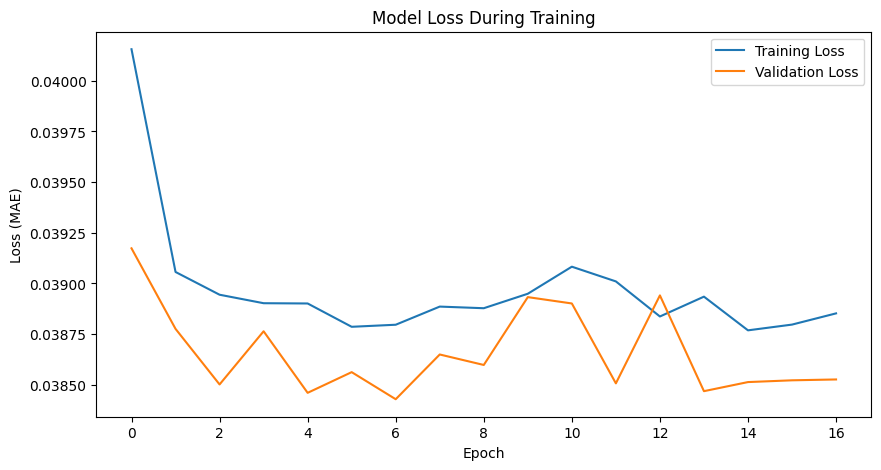

In [ ]:

# %% [markdown]
# ## 17. Plot Training History

# %%
if history:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MAE)')
    plt.legend()
    plt.show()
else:
    print("No training history to plot.")


In [ ]:

# %% [markdown]
# ## 18. Calculate Reconstruction Error

# %%
loss_df = pd.DataFrame() # Initialize
if model is not None and X_sequences.size > 0:
    print("Calculating reconstruction errors...")
    # Get predictions (reconstructed sequences)
    X_pred = model.predict(X_sequences)

    # Calculate MAE for each sequence
    mae_loss = np.mean(np.abs(X_pred - X_sequences), axis=1)
    # Reshape mae_loss to be 1D array of errors per sequence
    mae_loss = mae_loss.reshape(-1)

    # Add reconstruction error to a DataFrame for analysis
    # Ensure the index aligns correctly with the end of the sequence window
    if len(mae_loss) > 0:
         loss_df = pd.DataFrame({
             # Index aligns with end of sequence
             'timestamp': hourly_hits_pd.index[TIME_STEPS-1 : TIME_STEPS-1 + len(mae_loss)],
             'reconstruction_error': mae_loss
         })
         loss_df.set_index('timestamp', inplace=True)
         print("Reconstruction errors calculated.")
         print(loss_df.head())
    else:
         print("Prediction resulted in empty output. Cannot calculate errors.")

else:
    print("Model not trained or no sequences available. Skipping error calculation.")


Calculating reconstruction errors...
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 498ms/step
Reconstruction errors calculated.
                     reconstruction_error
timestamp                                
2020-06-08 05:00:00              0.028438
2020-06-08 06:00:00              0.027365
2020-06-08 07:00:00              0.027365
2020-06-08 08:00:00              0.027364
2020-06-08 09:00:00              0.027363


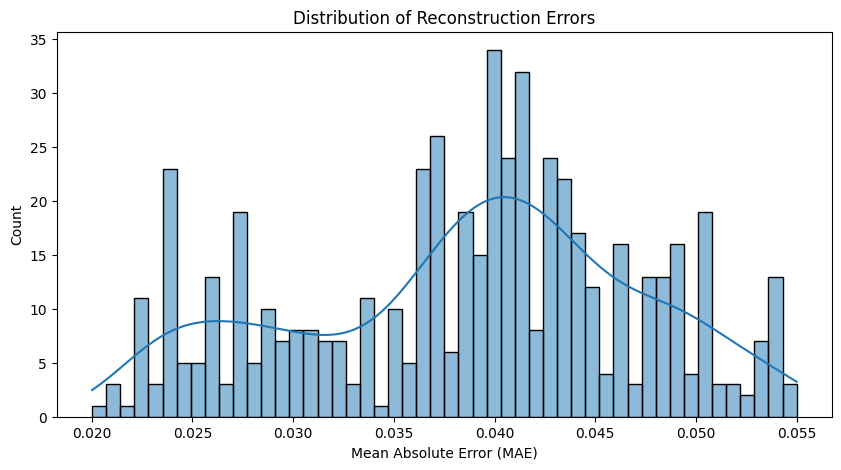

In [ ]:

# %% [markdown]
# ## 19. Plot Error Distribution

# %%
if not loss_df.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(loss_df['reconstruction_error'], bins=50, kde=True)
    plt.title('Distribution of Reconstruction Errors')
    plt.xlabel('Mean Absolute Error (MAE)')
    plt.show()
else:
    print("No reconstruction errors to plot.")


In [ ]:

# %% [markdown]
# ## 20. Determine Anomaly Threshold

# %%
threshold = np.inf # Initialize high
if not loss_df.empty:
    # Common approach: Use a percentile of the reconstruction error
    threshold_percentile = 0.98 # Adjust percentile based on error distribution and desired sensitivity
    threshold = loss_df['reconstruction_error'].quantile(threshold_percentile)
    print(f"Anomaly Threshold ({threshold_percentile*100:.0f}th percentile of MAE): {threshold:.4f}")
else:
    print("Cannot determine threshold without reconstruction errors.")


Anomaly Threshold (98th percentile of MAE): 0.0538


Identifying and visualizing anomalies...
Anomalies found (LSTM Autoencoder): 11
Detected Anomalous Hours (Top 10 by Hit Count):
                     hourly_hit_count  reconstruction_error
2020-06-25 06:00:00            247003              0.055003
2020-06-24 19:00:00            122243              0.054141
2020-06-24 20:00:00                 0              0.054139
2020-06-25 07:00:00                 0              0.055001
2020-06-25 08:00:00                 0              0.054999
2020-06-25 09:00:00                 0              0.053916
2020-06-25 10:00:00                 0              0.053915
2020-06-25 11:00:00                 0              0.053913
2020-06-25 12:00:00                 0              0.053910
2020-06-25 13:00:00                 0              0.053908


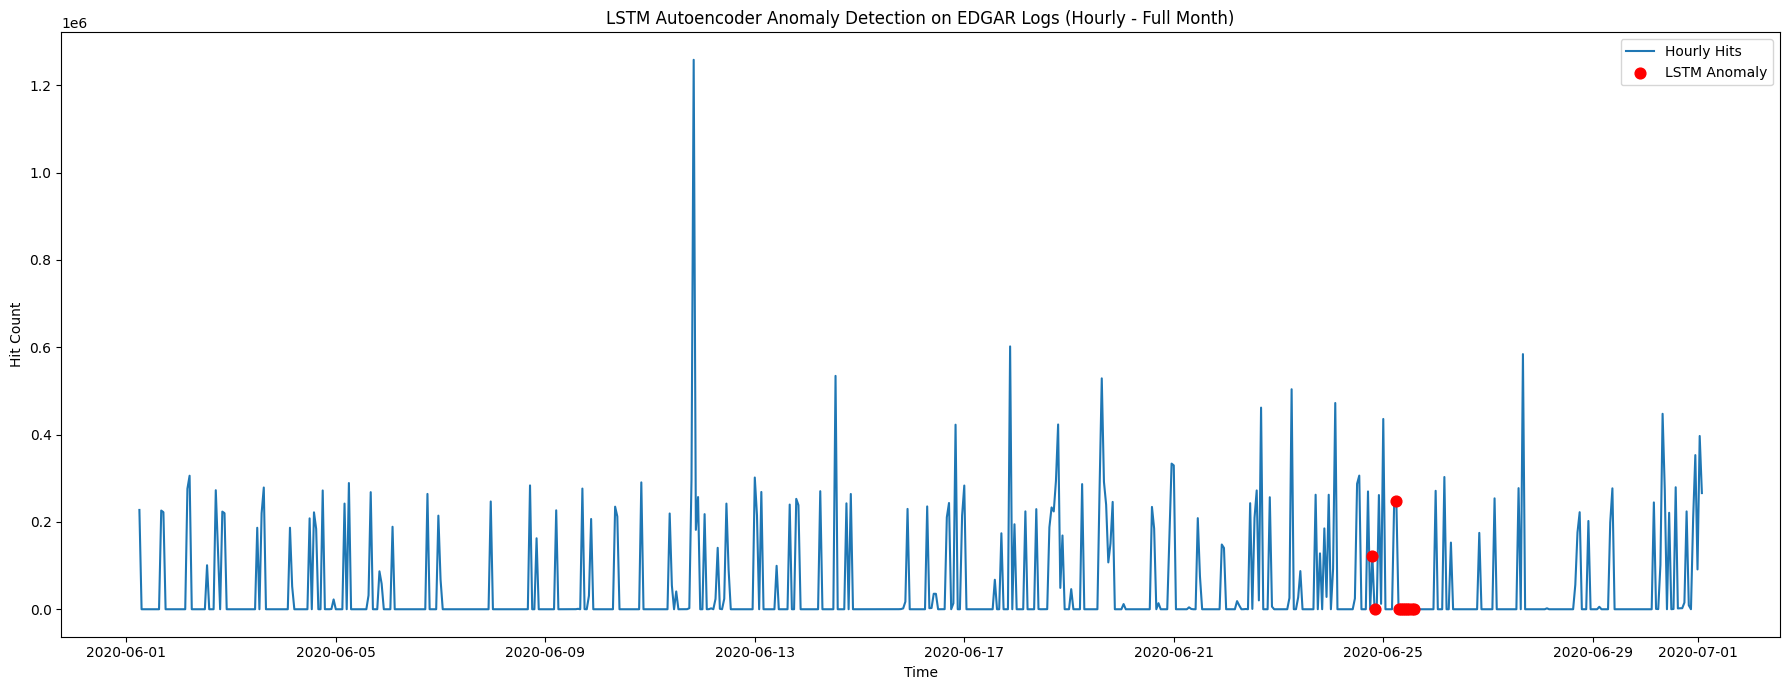

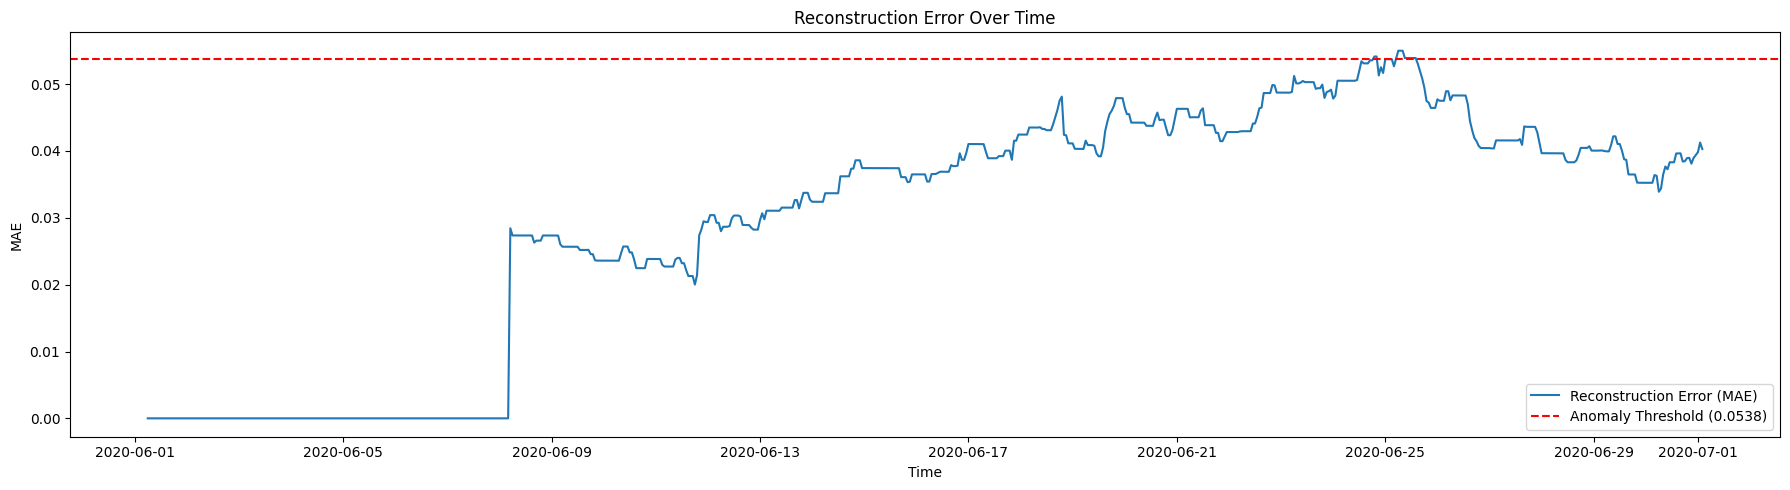

In [ ]:

# %% [markdown]
# ## 21. Identify & Visualize Anomalies

# %%
if not hourly_hits_pd.empty and not loss_df.empty:
    print("Identifying and visualizing anomalies...")
    # Merge errors back with original data
    results_pd = hourly_hits_pd.merge(loss_df, left_index=True, right_index=True, how='left')

    # Identify anomalies
    results_pd['is_anomaly_lstm'] = results_pd['reconstruction_error'] > threshold
    anomalies_lstm_pd = results_pd[results_pd['is_anomaly_lstm']]

    print(f"Anomalies found (LSTM Autoencoder): {len(anomalies_lstm_pd)}")
    if not anomalies_lstm_pd.empty:
        print("Detected Anomalous Hours (Top 10 by Hit Count):")
        print(anomalies_lstm_pd.sort_values('hourly_hit_count', ascending=False).head(10)[['hourly_hit_count', 'reconstruction_error']])

    # Plot results
    plt.figure(figsize=(18, 7))
    plt.plot(results_pd.index, results_pd['hourly_hit_count'], label='Hourly Hits')
    plt.scatter(anomalies_lstm_pd.index, anomalies_lstm_pd['hourly_hit_count'],
                color='red', label='LSTM Anomaly', s=60, zorder=5)
    plt.title('LSTM Autoencoder Anomaly Detection on EDGAR Logs (Hourly - Full Month)')
    plt.xlabel('Time')
    plt.ylabel('Hit Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot reconstruction error and threshold
    plt.figure(figsize=(18, 5))
    plt.plot(results_pd.index, results_pd['reconstruction_error'].fillna(0), label='Reconstruction Error (MAE)') # Fill NA for plotting
    plt.axhline(threshold, color='red', linestyle='--', label=f'Anomaly Threshold ({threshold:.4f})')
    plt.title('Reconstruction Error Over Time')
    plt.xlabel('Time')
    plt.ylabel('MAE')
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("Cannot identify or visualize anomalies without data and errors.")


In [ ]:

# %% [markdown]
# ## 22. Using Spark SQL (Example)
# Demonstrate querying the original data using Spark's SQL interface. Requires the original `df` to be available.

# %%
print("\n--- Demonstrating Spark SQL ---")
# Register the original DataFrame as a temporary view
# Ensure 'df' still holds the original loaded data
sql_view_created = False
try:
    if 'df' in locals() and df is not None and df.count() > 0:
        df.createOrReplaceTempView("edgar_logs_view")
        print("Temporary view 'edgar_logs_view' created.")
        sql_view_created = True
    else:
        print("Original DataFrame 'df' not available or empty for creating SQL view.")
except Exception as e:
     print(f"Error creating SQL view: {e}")


# %% [markdown]
# ### Spark SQL: Top 10 CIKs

# %%
if sql_view_created:
    try:
        print("Calculating Top 10 CIKs using Spark SQL:")
        # Note the double backslash needed for regex within SQL string
        top_ciks_sql = spark.sql("""
            SELECT
                regexp_extract(uri_path, '/data/(\\\\d+)/', 1) as CIK,
                COUNT(*) as cik_hit_count
            FROM edgar_logs_view
            WHERE regexp_extract(uri_path, '/data/(\\\\d+)/', 1) != ''
            GROUP BY CIK
            ORDER BY cik_hit_count DESC
            LIMIT 10
        """)
        top_ciks_sql.show(truncate=False)
    except Exception as e:
        print(f"Error running Spark SQL query for CIKs: {e}")
else:
    print("Skipping CIK query as SQL view was not created.")

# %% [markdown]
# ### Spark SQL: Hourly Hits (Sample)

# %%
if sql_view_created:
    try:
        print("\nCalculating Hourly Hits using Spark SQL (Sample):")
        hourly_hits_sql = spark.sql("""
            SELECT
                date_trunc('hour', _time) as hourly_timestamp,
                COUNT(*) as hourly_hit_count
            FROM edgar_logs_view
            GROUP BY date_trunc('hour', _time)
            ORDER BY hourly_timestamp
            LIMIT 10
        """)
        hourly_hits_sql.show(truncate=False)
    except Exception as e:
        print(f"Error running Spark SQL query for hourly hits: {e}")
else:
    print("Skipping hourly hits query as SQL view was not created.")



--- Demonstrating Spark SQL ---
Temporary view 'edgar_logs_view' created.
Calculating Top 10 CIKs using Spark SQL:
+-------+-------------+
|CIK    |cik_hit_count|
+-------+-------------+
|789019 |215723       |
|58492  |184369       |
|1193221|154115       |
|878927 |126992       |
|19617  |95909        |
|1731289|94052        |
|1114446|91109        |
|886982 |77607        |
|1610853|71660        |
|1809987|68812        |
+-------+-------------+


Calculating Hourly Hits using Spark SQL (Sample):
+-------------------+----------------+
|hourly_timestamp   |hourly_hit_count|
+-------------------+----------------+
|2020-06-01 06:00:00|227410          |
|2020-06-01 16:00:00|226017          |
|2020-06-01 17:00:00|222315          |
|2020-06-02 04:00:00|276014          |
|2020-06-02 05:00:00|305789          |
|2020-06-02 13:00:00|100776          |
|2020-06-02 17:00:00|272590          |
|2020-06-02 18:00:00|138459          |
|2020-06-02 20:00:00|223606          |
|2020-06-02 21:00:00|220055 

In [ ]:





# ## 23. Stop Spark Session

# %%
print("\nStopping Spark Session.")
spark.stop()

# %% [markdown]
# ---
# End of Notebook
# ---



Stopping Spark Session.
